# Forecasting Medicaid Prescription Drug Demand
*Capstone project for BrainStation Data Science diploma*

Author - Albert King<br>
Last Modified - 11 April 2023<br>
Contact - awkchemistry@gmail.com<br>

## Notebook 2

Drug shortages directly contribute to preventable deaths, drug stockpiling and rationing by hospitals and governments, and inflated drug costs. In effort to characterize the situation of current drug shortages, this project looks at reported US Medicaid drug claims by states for years 1991-2022, the most recent data currently available. In combination with the FDA's current list of shortages and anticipated shortages, time series analysis is used to forecast future demand.

This project is divided into 4 Jupyter notebooks:

- Notebook 1 imports Medicaid data into a MySQL database, explores and cleans prescription data, and prepares a list of drugs common to the Medicaid data and current FDA shortages.
- Notebook 2 explores and models the prescription data aggregated to total prescriptions per year nationwide. Fitting is accomplished through ARIMA and Facebook Prophet models.
- Notebook 3 models the data using an ARIMA multiple-point output convolutional neural network (CNN). It is separate due incompatabilities between the environments used for Notebooks 1, 2, and 4 with TensorFlow/Keras.
- Notebook 4 ingests, cleans, models, and forecasts prescription demand for individual drugs en masse.

Medicaid datasets were downloaded locally as CSV files from https://data.medicaid.gov/datasets?theme%5B0%5D=State+Drug+Utilization for all years available. The CSV files were brought into MySQL initially using command line as MySQLWorkbench was not able to handle the size of the files. This method is recreated below so as to aggregate methods into Jupyter notebooks, though the initial command line code is included in an appendix. Current drug shortages were downloaded from https://www.accessdata.fda.gov/scripts/drugshortages/default.cfm as CSV files.

Raw data area available at https://1drv.ms/f/s!Ah-g64c_vUtNoCNJ86SVWQk5qyoh?e=GNFof6.

## Aggregate Data Fitting

This notebook imports processed Medicaid data from notebook 1 and applies ARIMA and Facebook Prophet models to fit aggregate nationwide prescription demand. Notebook 3 continues this process using a NN. Summary of the results is described in this notebook. Methodology is summarized in the capstone summary PDF document.

## Table of Contents

- [Imports](#imports)
- [Decompositon](#decomposition)
- [Baseline Determination](#baseline-determination)
- [ARIMA Model](#arima-model)
- [Facebook Prophet](#facebook-prophet)
- [Multiple-Output RNN](#multiple-output-rnn)
- [Conclusions](#conclusions)

## Imports

Notebook imports are listed below.

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import QuarterEnd
from statsmodels.api import tsa

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from prophet import Prophet
from prophet.plot import plot_plotly

# warnings occur due to SARIMAX fitting - they are silenced here for clarity.
# WARNING WARNING WARNING
import warnings
warnings.filterwarnings("ignore")
# WARNING WARNING WARNING

Example data from Notebook 1, quarterly prescriptions by state and year, will be imported for fitting in this notebook.

In [43]:
# import data exported from Book 1
parent_df = pd.read_csv('data/quarterly_prescriptions.csv',index_col=0).T

# make sure data look as expected
parent_df.head()

,AK,AL,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
03/31/1991,44447.0,541209.0,NaN,905764.0,6200227.0,379533.0,454890.0,58932.0,130940.0,2489054.0,...,59310.0,1530412.0,2118592.0,NaN,128515.0,1069960.0,893352.0,NaN,747579.0,38003.0
06/30/1991,64671.0,908574.0,NaN,904910.0,7569682.0,559830.0,950321.0,NaN,180563.0,3393291.0,...,122473.0,2044949.0,3066577.0,303904.0,193322.0,1482027.0,1264073.0,790213.0,1181954.0,75244.0
09/30/1991,78263.0,1055462.0,NaN,913206.0,9900547.0,541989.0,665685.0,106161.0,195679.0,3206257.0,...,114451.0,2119905.0,3447844.0,281662.0,207355.0,1407907.0,1294843.0,751653.0,1418717.0,65111.0
12/31/1991,88664.0,1329204.0,NaN,970455.0,8893709.0,571188.0,816080.0,110418.0,200222.0,3938687.0,...,122966.0,2298385.0,3524320.0,348601.0,189977.0,1654946.0,1611392.0,719667.0,1898152.0,78369.0
03/31/1992,85188.0,1560547.0,NaN,906149.0,11371060.0,578758.0,718913.0,131572.0,202459.0,3841718.0,...,143393.0,2514538.0,4221591.0,370368.0,210985.0,1754570.0,1835231.0,785094.0,1985105.0,61453.0


The data look as expected from Notebook 1. In order to fit nationwide data, the states' data will be summed below.

In [44]:
# find total for each date

# instantiate empty dict 
summary_dict = {}

# loop through rows
for i in parent_df.index:
    # for each date add sum of that quarter to dict
    summary_dict[i] = parent_df.loc[i].sum()

# convert to a dataframe
summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=['Prescriptions'])

# ensure that index is datetime type
summary_df.index = pd.to_datetime(summary_df.index)

The data can be visualized as below.

In [45]:
# visualize summed data
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Annually, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(summary_df.index), y = list(summary_df['Prescriptions']), mode='markers'),layout=layout)
fig.update()
fig.show()

The summed data show an increase in prescriptions from 1991 until 2008, when prescriptions suddenly decrease, and then regain rise with a slight plateau around 2020. After this time there is a slight decline in prescriptions. It looks like there could possibly be some seasonality, but it is not obvious if this is real. We'll decompose the data next.

## Decomposition

Let's do some classic time series analysis, trend, seasonal, and residual decomposition, to get familiar with the data.

In [46]:
summary_df = summary_df.asfreq(freq='Q')
summary_df.interpolate(method='ffill', inplace=True)
summary_df.isna().sum()

Prescriptions    0
dtype: int64

In [47]:
# decomposition of dataset

# instantiate dict and df containers
analysis_dict = {}
analysis_df_full = pd.DataFrame.empty

# instantiate decomposition model
decomposition = tsa.seasonal_decompose(summary_df, model='additive')

# decomposition components to dict
analysis_dict={'trend':dict(decomposition.trend),'seasonal':dict(decomposition.seasonal),'residual':dict(decomposition.resid)}

# dict to df
analysis_df_full = pd.DataFrame(analysis_dict)

# now we can visualize the components
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(
    name = 'Trend',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['trend']),), row=1, col=1)
fig.append_trace(go.Scatter(
    name = 'Seasonal',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['seasonal']),), row=2, col=1)
fig.append_trace(go.Scatter(
    name = 'Residuals',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['residual']),), row=3, col=1)
fig.update_layout(height=600, width=800, title_text=f"Prescription Stacked Subplots")
fig.show()

There's a clear trend in the data increasing with time. The decomposition has found some seasonality, and the residuals look pretty good/stationary. Nevertheless, let's try differencing to address some of the trend. Because the data are divided into quarters I'll try differencing across 4 quarters.

In [48]:
# differencing 1 quarter

# local copy of df so no changes are made.
increment_1_df = summary_df.copy(deep=True)

# container for differenced values
new_prescription_values = []

# increment index, exclude the first data point as it cannot be differenced
for h, i in enumerate(increment_1_df.index):
    # skip first data point
    if h == 0:
        pass
    
    # increment by 1 quarter, subtract prior quarter
    else:
        increment = i-QuarterEnd(1)
        new_prescription_values.append(increment_1_df.loc[i]['Prescriptions'] - increment_1_df.loc[increment]['Prescriptions'])

# dropt first data point
increment_1_df.drop(increment_1_df.index[0],axis=0,inplace=True)

# update df
increment_1_df['Prescriptions'] = new_prescription_values

# display differenced data
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Annually, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(increment_1_df.index), y = list(increment_1_df['Prescriptions']), mode='markers'),layout=layout)
fig.update()
fig.show()


# create decomposition

# instantiate containers
analysis_dict = {}
analysis_df_full = pd.DataFrame.empty

# decompose
decomposition = tsa.seasonal_decompose(increment_1_df, model='additive')

# decomposition to dict
analysis_dict={'trend':dict(decomposition.trend),'seasonal':dict(decomposition.seasonal),'residual':dict(decomposition.resid)}

# dict to df
analysis_df_full = pd.DataFrame(analysis_dict)

# display decomposed data
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(
    name = 'Trend',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['trend']),
), row=1, col=1)
fig.append_trace(go.Scatter(
    name = 'Seasonal',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['seasonal']),
), row=2, col=1)
fig.append_trace(go.Scatter(
    name = 'Residuals',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['residual']),
), row=3, col=1)
fig.update_layout(height=600, width=800, title_text=f"Prescription Stacked Subplots")
fig.show()

In [49]:
# differencing 2 quarters

# local copy of df so no changes are made.
increment_2_df = summary_df.copy(deep=True)

# container for differenced values
new_prescription_values = []

# increment index, exclude the first 2 data points as they cannot be differenced
for h, i in enumerate(increment_2_df.index):
    # skip first 2 data points
    if h < 2:
        pass
    
    # increment by 2 quarters, subtract 2 quarters prior
    else:
        increment = i-QuarterEnd(2)
        new_prescription_values.append(increment_2_df.loc[i]['Prescriptions'] - increment_2_df.loc[increment]['Prescriptions'])

# drop first 2 data points
increment_2_df.drop(increment_2_df.index[0:2],axis=0,inplace=True)

# update df
increment_2_df['Prescriptions'] = new_prescription_values


# display differenced data
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Annually, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(increment_2_df.index), y = list(increment_2_df['Prescriptions']), mode='markers'),layout=layout)
fig.update()
fig.show()


# create decomposition

# instantiate containers
analysis_dict = {}
analysis_df_full = pd.DataFrame.empty

# decompose
decomposition = tsa.seasonal_decompose(increment_2_df, model='additive')

# decomposition to dict
analysis_dict={'trend':dict(decomposition.trend),'seasonal':dict(decomposition.seasonal),'residual':dict(decomposition.resid)}

# dict to df
analysis_df_full = pd.DataFrame(analysis_dict)

# display decomposed data
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(
    name = 'Trend',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['trend']),
), row=1, col=1)
fig.append_trace(go.Scatter(
    name = 'Seasonal',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['seasonal']),
), row=2, col=1)
fig.append_trace(go.Scatter(
    name = 'Residuals',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['residual']),
), row=3, col=1)
fig.update_layout(height=600, width=800, title_text=f"Prescription Stacked Subplots")
fig.show()

In [50]:
# differencing 3 quarters

# local copy of df so no changes are made.
increment_3_df = summary_df.copy(deep=True)

# container for differenced values
new_prescription_values = []

# increment index, exclude the first 3 data points as they cannot be differenced
for h, i in enumerate(increment_3_df.index):
    # skip first 3 data points
    if h < 3:
        pass
    
    # increment by 3 quarters, subtract 3 quarters prior
    else:
        increment = i-QuarterEnd(3)
        new_prescription_values.append(increment_3_df.loc[i]['Prescriptions'] - increment_3_df.loc[increment]['Prescriptions'])

# drop first 3 data points
increment_3_df.drop(increment_3_df.index[0:3],axis=0,inplace=True)

# update df
increment_3_df['Prescriptions'] = new_prescription_values

# display differenced data
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Annually, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(increment_3_df.index), y = list(increment_3_df['Prescriptions']), mode='markers'),layout=layout)
fig.update()
fig.show()


# create decomposition

# instantiate containers
analysis_dict = {}
analysis_df_full = pd.DataFrame.empty

# decompose
decomposition = tsa.seasonal_decompose(increment_3_df, model='additive')

# decomposition to dict
analysis_dict={'trend':dict(decomposition.trend),'seasonal':dict(decomposition.seasonal),'residual':dict(decomposition.resid)}

# dict to df
analysis_df_full = pd.DataFrame(analysis_dict)

# display decomposed data
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(
    name = 'Trend',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['trend']),
), row=1, col=1)
fig.append_trace(go.Scatter(
    name = 'Seasonal',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['seasonal']),
), row=2, col=1)
fig.append_trace(go.Scatter(
    name = 'Residuals',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['residual']),
), row=3, col=1)
fig.update_layout(height=600, width=800, title_text=f"Prescription Stacked Subplots")
fig.show()

In [51]:
# differencing 4 quarters

# local copy of df so no changes are made.
increment_4_df = summary_df.copy(deep=True)

# container for differenced values
new_prescription_values = []

# increment index, exclude the first 4 data points as they cannot be differenced
for h, i in enumerate(increment_4_df.index):
    # skip first 4 data points
    if h < 4:
        pass
    
    # increment by 4 quarters, subtract 4 quarters prior
    else:
        increment = i-QuarterEnd(2)
        new_prescription_values.append(increment_4_df.loc[i]['Prescriptions'] - increment_4_df.loc[increment]['Prescriptions'])

# drop first 4 data points
increment_4_df.drop(increment_4_df.index[0:4],axis=0,inplace=True)

# update df
increment_4_df['Prescriptions'] = new_prescription_values


# display differenced data
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Annually, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(increment_4_df.index), y = list(increment_4_df['Prescriptions']), mode='markers'),layout=layout)
fig.update()
fig.show()


# create decomposition

# instantiate containers
analysis_dict = {}
analysis_df_full = pd.DataFrame.empty

# decompose
decomposition = tsa.seasonal_decompose(increment_4_df, model='additive')

# decomposition to dict
analysis_dict={'trend':dict(decomposition.trend),'seasonal':dict(decomposition.seasonal),'residual':dict(decomposition.resid)}

# dict to df
analysis_df_full = pd.DataFrame(analysis_dict)

# display decomposed data
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(
    name = 'Trend',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['trend']),
), row=1, col=1)
fig.append_trace(go.Scatter(
    name = 'Seasonal',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['seasonal']),
), row=2, col=1)
fig.append_trace(go.Scatter(
    name = 'Residuals',
    x = list(analysis_df_full.index),
    y = list(analysis_df_full['residual']),
), row=3, col=1)
fig.update_layout(height=600, width=800, title_text=f"Prescription Stacked Subplots")
fig.show()

Reviewing the differenced data, a single difference seems to remove all trend. Seasonality is found in each version, and the residuals are comparable for each. This suggests that a single difference is enough to make the data stationary. This can be verified by autocorrelation functions.

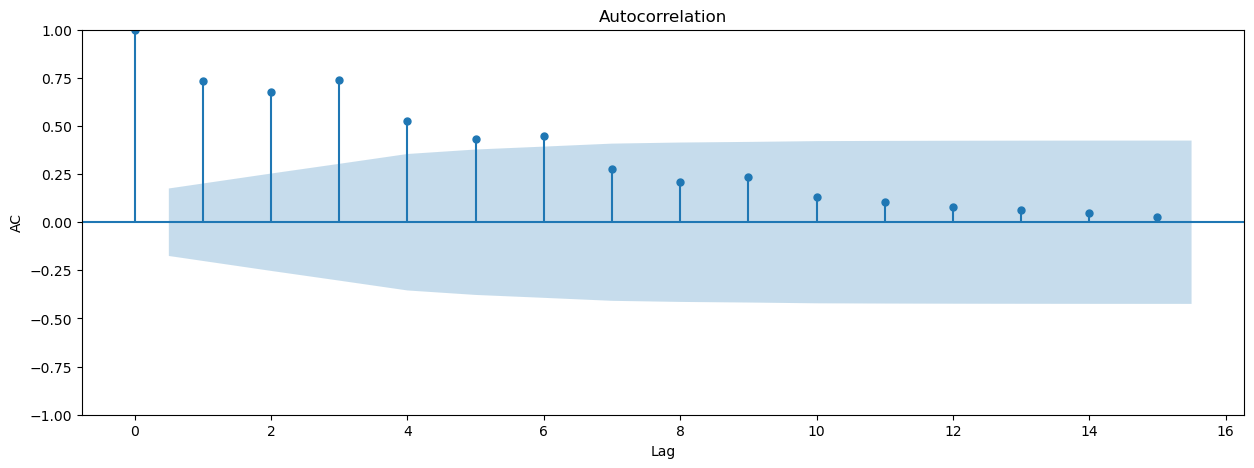

In [52]:
# autocorrelation function

plt.figure(figsize=(15, 5))
plot_acf(summary_df, lags=15, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('AC')
plt.show()

The autocorrelation function shows differences of 1-6 are significant. To verify if all of these differences are significant, or how much each contributes to the significance, I'll run a partial autocorrelation function.

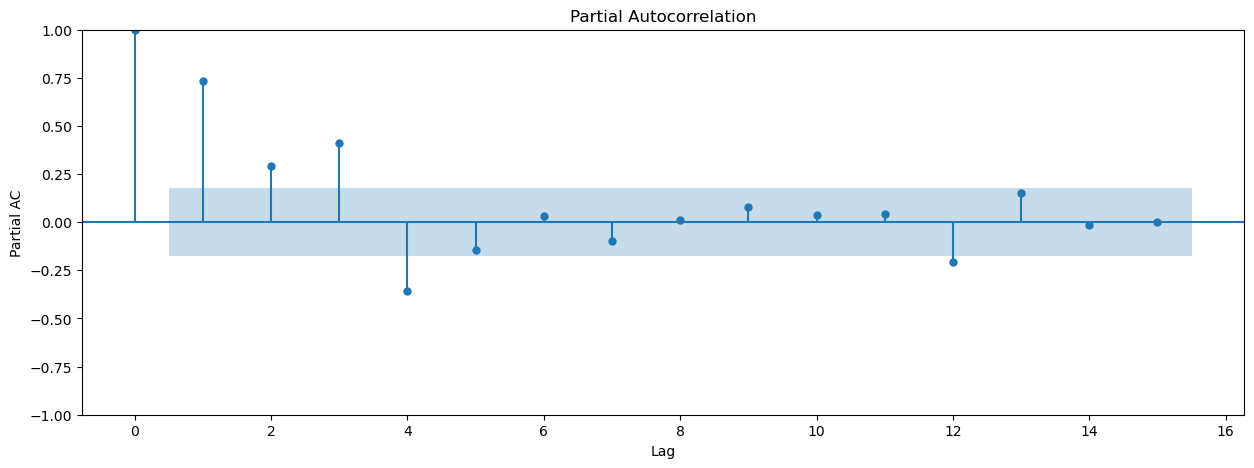

In [53]:
# partial autocorrelation function

plt.figure(figsize=(15, 5))
plot_pacf(summary_df, lags=15, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

The partial autocorrelation function shows that the greatest difference comes from the first step; there are minor contributions from the second, third, and fourth as well. This may be consistent with year-over-year changes. Next, let's get a baseline - just the mean - and calculate MAPE and SMAPE for the mean of the data.

## Baseline Determination

The Mean Absolute Percentage Error and Symmetric Mean Absolute Percentage Error - respectively MAPE and SMAPE - are instantiated as functions below. While MAPE is useful for this analysis, some data have zero prescriptions at some points, and the predictions could potentially predict zero. The SMAPE is more robust to zero values, so it will be used more frequently in these notebooks. Thee functions are defined, and then a baseline mean is determined.

In [65]:
# defining MAPE and SMAPE functions

def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Input is series of known and then predicted values from time series.
    
    Calculate the mean absolute percentage error.
    
    Find the prediction error and divide by the true value, then average.
    """
    
    error = true_values - predicted_values
    
    absolute_percentage_error = np.abs(error/true_values)
    
    mape = absolute_percentage_error.mean() * 100
    
    return mape

def symmetric_mean_absolute_percentage_error(true_values, predicted_values):
    """
    Input is series of known and then predicted values from time series.

    Calculation is more robust to zeros in data, such as years with zero prescriptions
    or projections of zero.

    Calculate the symmetric mean absolute percentage error.
    
    Find the prediction error and divide by the true+predicted value, then average.
    """

    # calculate numerator - difference in values
    numerator = abs(predicted_values-true_values)
    
    # calculate denominator, sum of absolute true/predicted
    denominator = abs(true_values)+abs(predicted_values)
    
    division = numerator/denominator
    
    summed_div = division.sum()
    
    # average
    smape = round((100/(len(true_values)))*summed_div,2)
    
    return smape

We'll now calculate the mean, plot the data with the mean, and determine evaluation metrics.

In [70]:
# determine mean, plot, find MAPE/SMAPE

# print and calculate mean
print(f"The mean quarterly number of prescriptions for all available data is {round(summary_df['Prescriptions'].mean(),0)}, plotted as a red line below.")

# print data with mean
layout = go.Layout(xaxis={'title': 'Year'}, yaxis={'title': 'Prescriptions'}, title={'text': 'Prescriptions Reimbursed Quarterly, 1991-2022'})
fig = go.Figure(data=go.Scatter(x = list(summary_df.index), y = list(summary_df['Prescriptions']), mode='markers'),layout=layout)
fig.add_hline(y=summary_df['Prescriptions'].mean(), line_color='red')
fig.show()

# a dataframe of values of the mean is created for MAPE/SMAPE
mean_prescriptions = pd.DataFrame.from_dict({i: 136620699 for i in summary_df.index}, orient='index', columns=['Prescriptions'])

# MAPE/SMAPE is calculated for the mean value
print(f"Using mean prescriptions, the MAPE is {round(mean_absolute_percentage_error(summary_df['Prescriptions'],mean_prescriptions['Prescriptions']),2)}%;\
 the SMAPE is {round(symmetric_mean_absolute_percentage_error(summary_df['Prescriptions'],mean_prescriptions['Prescriptions']),2)}%.")

The mean quarterly number of prescriptions for all available data is 153236124.0, plotted as a red line below.


Using mean prescriptions, the MAPE is 35.92%; the SMAPE is 17.17%.


The mean number of prescriptions across all years data is available is 153236124.0. Comparing this as a baseline, the MAPE is and the SMAPE is. Having ingested and observed the data and established a baseline we'll move on to time series modeling.

## ARIMA Model

I start with the ARIMA model and will focus on this model in Notebook 4. In order to efficiently model and describe large quantities of data I will break down the method of employing the ARIMA model here, and it's use will be more condensed in Notebook 4. In summary, I want to be able to consider many ARIMA (p, d, q) parameters. So, I'll first iterate the data through a series of p, d, and q values, fitting and determining the SMAPE for each. From there, I'll manually review the SMAPE scores vial a 3D plot of parameters versus SMAPE, and choose promising values to investigate. I'll then move to choosing the most effective values, taking their mean, and evaluating the mean fit.

In [56]:
# finding parameters

# I'll use train data up to the cutoff date, leaving the remainder for test data.
cutoff = '2020-12-31'

# string to datatime
cutoff = pd.to_datetime(cutoff)

# instantiate empty containers, run counter.
train_dict = {}
test_dict = {}
run_num = 0

# iterate through possible p, d, and q values
for p in range(0,6):
    for d in range(0,6):
        for q in range(0,6):

            # provide an update for the slow process
            print(f"Running series p {p}, d {d}, q {q}",end="\r")
            
            # there are often errors due to poor fits, so try is used to ignore these and keep iterating
            try:
                
                # copy df so parent isn't modified
                predict_df = summary_df.copy(deep=True)
                
                # rearrange dataframe to account for train/test
                predict_df.index = pd.to_datetime(predict_df.index)
                first_day = predict_df.index.min()
                last_day = predict_df.index.max()
                full_range = pd.date_range(start=first_day, end=last_day, freq="Q")
                
                # fill any blanks
                predict_df.fillna(method='ffill',inplace=True)

                # instantiate train/test
                train = predict_df.loc[predict_df.index <= cutoff].dropna()
                test = predict_df.loc[predict_df.index > cutoff]

                # model, fit to train
                model = SARIMAX(train, order=(p, d, q), trend="c")
                model_fit = model.fit(disp=0)

                # predicted fit
                predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)
                
                # deterine evaluation metrics
                train_smape = symmetric_mean_absolute_percentage_error(pd.Series(list(train['Prescriptions'])), pd.Series(list(predictions[train.index])))
                test_smape = symmetric_mean_absolute_percentage_error(pd.Series(list(test['Prescriptions'])), pd.Series(list(predictions[test.index])))

                # convert to dfs
                train_dict[run_num] = {'p':p,'d':d,'q':q,'val':train_smape}
                test_dict[run_num] = {'p':p,'d':d,'q':q,'val':test_smape}
                
                # increment
                run_num+=1
            except:
                pass

# dicts to df
train_vals_df = (pd.DataFrame(train_dict).T)
test_vals_df = (pd.DataFrame(test_dict).T)

# plot parameters versus train SMAPE
px.scatter_3d(train_vals_df, x='p',y='d',z='q',color='val',range_color=[6,9]).show()

Based on the visualization the best parameters appear to be between d = and with p and q values of at least . The data are reduced to be a bit more manageable below.

In [57]:
# select hyperparameters

# empty dict
combined_dict = {}

# find where both train and test SMAPE are < 100 adn summarize the best fits
for i in train_vals_df.index: # make a list of places where they overlap then plot
    
    # instances where both train/test SMAPE are low
    if 0 < train_vals_df.loc[i,'val'] < 100 and 0 < test_vals_df.loc[i,'val'] < 100:
        
        # aggregate their parameters
        combined_dict[i] = {'p':train_vals_df.loc[i,'p'],
                            'd':train_vals_df.loc[i,'d'],
                            'q':train_vals_df.loc[i,'q'],
                            'val':(train_vals_df.loc[i,'val']+test_vals_df.loc[i,'val'])/2}

# dict to df
combined_df = pd.DataFrame(combined_dict).T

# remove instances lower than the mean
for i in combined_df.index:
    if combined_df.loc[i,'val'] > combined_df['val'].mean():
        combined_df.drop(index=i,inplace=True)

# choose color code threshold
high_threshold = combined_df.describe()['val'][4]
low_threshold = combined_df.describe()['val'][3]

# visualize
px.scatter_3d(combined_df, x='p',y='d',z='q',color='val',range_color=[low_threshold,high_threshold]).show()

# display table of parameters
#  NOTE THAT 'val' IS THE AVERAGE TRAIN/TEST SMAPE
display(combined_df.sort_values('val'))

,p,d,q,val
57,1.0,3.0,3.0,4.039967
6,0.0,1.0,0.0,4.292027
56,1.0,3.0,2.0,4.807457
42,1.0,1.0,0.0,4.809738
7,0.0,1.0,1.0,4.814872
...,...,...,...,...
77,2.0,0.0,5.0,8.477266
74,2.0,0.0,2.0,8.626697
35,0.0,5.0,5.0,8.714990
28,0.0,4.0,4.0,8.980004


Looking at the winnowed down parameters, the best appears to be p = 1, d = 3, q = 3. So, I'll look at those values specifically next.

In [73]:
# specific parameter ARIMA

# instantiate parameter values
p, d, q = 1, 3, 3

# copy to not damage df
predict_df = summary_df.copy(deep=True)

# index to datetime
predict_df.index = pd.to_datetime(predict_df.index)

# determine length of train/test
first_day = predict_df.index.min()
last_day = predict_df.index.max()
full_range = pd.date_range(start=first_day, end=last_day, freq="Q")

# fill any blanks
predict_df.fillna(method='ffill',inplace=True)

# define train/test
train = predict_df.loc[predict_df.index <= cutoff].dropna()
test = predict_df.loc[predict_df.index > cutoff]

# instantiate model, fit
model = SARIMAX(train, order=(p, d, q), trend="c")
model_fit = model.fit(disp=0)

# get fit model
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

# determine SMAPE for train and test
train_smape = mean_absolute_percentage_error(pd.Series(list(train['Prescriptions'])), pd.Series(list(predictions[train.index])))
test_smape = mean_absolute_percentage_error(pd.Series(list(test['Prescriptions'])), pd.Series(list(predictions[test.index])))

# display fit summary
display(model_fit.summary())

# visualize train, test, prediction data
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(train.index), y = train['Prescriptions'], name = 'Train'))
fig.add_trace(go.Scatter(x=list(test.index), y = test['Prescriptions'], name = 'Test'))
fig.add_trace(go.Scatter(x=list(predictions.index), y = predictions, name = 'Fit'))
fig.update_layout(title=f"Prescriptions Annually<Br>p = {p}, d = {d}, q = {q},")
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title = 'Year', yaxis_title='Prescriptions')
fig.show()

# print out SMAPE values
print(f"The train SMAPE is {round(train_smape,2)}% and the test SMAPE is {round(test_smape,2)}% with the parameters p = {p}, d = {d}, q = {q}.")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Prescriptions   No. Observations:                  120
Model:               SARIMAX(1, 3, 3)   Log Likelihood               -2274.876
Date:                Mon, 10 Apr 2023   AIC                           4561.752
Time:                        21:02:48   BIC                           4578.325
Sample:                    03-31-1991   HQIC                          4568.480
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.709e+04   3.49e+05      0.164      0.870   -6.27e+05    7.41e+05
ar.L1         -0.8891      0.413     -2.152      0.031      -1.699      -0.079
ma.L1         -0.9572      0.325     -2.946      0.003      -1.594      -0.320
ma.L2         -0.9204      0.554     -1.660      0.097      -2.007       0.166
ma.L3          0.8974      0.312      2.875      0.004       0.286       1.509
sigma2      8.541e+15   5.37e-06   1.59e+21      0.000    8.54e+15    8.54e+15
===================================================================================
Ljung-Box (L1) (Q):                  20.29   Jarque-Bera (JB):              1238.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+43. Standard errors may be unstable.
"""

The train SMAPE is 14.66% and the test SMAPE is 2.37% with the parameters p = 1, d = 3, q = 3.


In [74]:
# figure for presentation

# visualize train, test, prediction data
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(train.index), y = train['Prescriptions'], name = 'Train'))
fig.add_trace(go.Scatter(x=list(test.index), y = test['Prescriptions'], name = 'Test'))
fig.add_trace(go.Scatter(x=list(predictions.index), y = predictions, name = 'Fit'))
fig.update_layout(title=f"Prescriptions Reimbursed Quarterly, 1991-2022<Br>p = {p}, d = {d}, q = {q},")
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(xaxis_title = 'Year', yaxis_title='Prescriptions')
fig.show()

# print out SMAPE values
print(f"The train SMAPE is {round(train_smape,2)}% and the test SMAPE is {round(test_smape,2)}% with the parameters p = {p}, d = {d}, q = {q}.")

The train SMAPE is 14.66% and the test SMAPE is 2.37% with the parameters p = 1, d = 3, q = 3.


Our model visually appears to fit well to both train and test data, and the test SMAPE is relatively low. I'll take the average of the top parameters to try to optimize the fit.

In [75]:
# optimized parameters

# display avg of top parameters

# select top 5 parameter sets
top_combined = combined_df.sort_values('val').index[0:6]

# empty dict
avgd_fit_dict = {}

# for each top parameter set fit, record prediction
for ind in top_combined:
    
    # pull out parameters
    p, d, q = combined_df.loc[ind,'p'], combined_df.loc[ind,'d'], combined_df.loc[ind,'q']
    
    # copy df for safety
    predict_df = summary_df.copy(deep=True)
    
    # reorder dfs for train/test
    predict_df.index = pd.to_datetime(predict_df.index)
    first_day = predict_df.index.min()
    last_day = predict_df.index.max()
    full_range = pd.date_range(start=first_day, end=last_day, freq="Q")
    predict_df = predict_df.reindex(full_range)
    
    # fill any empty spaces
    predict_df.fillna(method='ffill',inplace=True)

    # define train/test
    train = predict_df.loc[predict_df.index <= cutoff].dropna()
    test = predict_df.loc[predict_df.index > cutoff]

    # instantiate model, fit
    model = SARIMAX(train, order=(p, d, q), trend="c")
    model_fit = model.fit(disp=0)

    # collect predictions
    predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

    # predictions to dict
    avgd_fit_dict[f'p{p}, d{d}, q{q}'] = predictions

# dict to df
avgd_fit_df = pd.DataFrame(avgd_fit_dict, index = list(predictions.index))

# find average of fits
avgd_fit_df['mean'] = avgd_fit_df.mean(axis=1)

# find train/test SMAPE
train_smape = mean_absolute_percentage_error(pd.Series(list(avgd_fit_df['mean'][0:len(predictions[train.index])])), pd.Series(list(predictions[train.index])))
test_smape = mean_absolute_percentage_error(pd.Series(list(avgd_fit_df['mean'][len(predictions[train.index]):])), pd.Series(list(predictions[test.index])))

# visualize data and fi
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(train.index), y = train['Prescriptions'], name = 'Train'))
fig.add_trace(go.Scatter(x=list(test.index), y = test['Prescriptions'], name = 'Test'))
fig.add_trace(go.Scatter(x=list(avgd_fit_df.index), y = avgd_fit_df['mean'], name = 'Averaged Fit'))
fig.update_layout(title="Prescriptions Annually<Br>Averaged Fit")
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title = 'Year', yaxis_title='Prescriptions')
fig.show()

# print the evaluation metrics
print(f"The train SMAPE is {round(train_smape,2)}% and the test SMAPE is {round(test_smape,2)}% with the top 5 predictions averaged.")

The train SMAPE is 8.93% and the test SMAPE is 2.64% with the top 5 predictions averaged.


In [76]:
# figure for presentation

# visualize data and fit
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(train.index), y = train['Prescriptions'], name = 'Train'))
fig.add_trace(go.Scatter(x=list(test.index), y = test['Prescriptions'], name = 'Test'))
fig.add_trace(go.Scatter(x=list(avgd_fit_df.index), y = avgd_fit_df['mean'], name = 'Averaged Fit'))
fig.update_layout(title="Prescriptions Reimbursed Quarterly, 1991-2022<Br>Averaged Fit")
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(xaxis_title = 'Year', yaxis_title='Prescriptions')
fig.show()

# print the evaluation metrics
print(f"The train SMAPE is {round(train_smape,2)}% and the test SMAPE is {round(test_smape,2)}% with the top 5 predictions averaged.")

The train SMAPE is 8.93% and the test SMAPE is 2.64% with the top 5 predictions averaged.


The SMAPE values for train and test are still very good. This method will be streamlined and quasi-pipelined in Notebook 4.

# Facebook Prophet

We can also take a look at the Facebook Prophet tool. While powerful, the model does not seem toe be meant to be modified, at least not readily. Hyperparameters are less readily accessible compared to the ARIMA model, and use is straightforward. Because of the results of the model, I have chosen to focus on ARIMA in my large data processing in Notebook 4.

In [71]:
# Prophet model

# select start date = beginning data
start = '03/31/1991'

# select end of train data
end = '12/31/2020'

# start and end to datetime type
start = pd.to_datetime(start)
end = pd.to_datetime(end)

# I chose variables to modify the changepoint scale, which is ultimately flexibility of the model
# and display its ability. The model will iterate through this list and provide a fit for each.
for x in [0.5,1,10,1000]:

    # protect parent df
    predict_df = summary_df.copy(deep=True)
    
    # update df for Prophet requirements - only accepts certain names
    predict_df.reset_index(inplace=True,names=['date'])
    predict_df['date'] = pd.to_datetime(predict_df['date'])

    # define train and test
    prophet_train = predict_df.loc[predict_df['date'] <= end]
    prophet_test = predict_df.loc[predict_df['date'] > end]
    prophet_train = prophet_train.loc[prophet_train['date'] >= start]
    
    # modify train/test for Prophet
    prophet_train.rename(columns={"date": "ds", 'Prescriptions': "y"}, inplace=True)
    prophet_test.rename(columns={"date": "ds", 'Prescriptions': "y"}, inplace=True)
    
    # instantiate model - note changgepoint is modified by loop variable
    model = Prophet(yearly_seasonality=4, changepoint_prior_scale = (.5 * x))
    
    # fit model
    model.fit(prophet_train)
    
    # model future
    future = model.make_future_dataframe(periods=(len(predict_df)-len(predict_df.loc[predict_df['date'] <= end])), freq="Q", include_history=True)
    forecast = model.predict(future)
    
    # plot results
    fig = plot_plotly(model, forecast)
    fig.show()
    
    # reorder to collect SMAPE
    predict_train = forecast['yhat'][0:len(model.history)]
    predict_test = forecast['yhat'][len(model.history):]
    real_train = predict_df['Prescriptions'][0:len(model.history)]
    real_test = predict_df['Prescriptions'][len(model.history):]

    # collect SMAPE
    train_smape = symmetric_mean_absolute_percentage_error(real_train, predict_train)
    test_smape = symmetric_mean_absolute_percentage_error(real_test, predict_test)
    print(f"The train SMAPE is {round(train_smape,2)}% and the test SMAPE is {round(test_smape,2)}%.")

15:49:15 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing


15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing


The train SMAPE is 8.83% and the test SMAPE is 1.33%.


15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing


The train SMAPE is 6.9% and the test SMAPE is 1.64%.


15:49:16 - cmdstanpy - INFO - Chain [1] start processing


The train SMAPE is 4.6% and the test SMAPE is 2.42%.


15:49:16 - cmdstanpy - INFO - Chain [1] done processing


The train SMAPE is 3.96% and the test SMAPE is 2.82%.


We can see that the fit improves as the `changepoint_prior_scale` modifying variable changes. The best test fit occurs at , and is comparable with the ARIMA model above.

# Multiple-Output RNN

Neural networks have also been applied to time series analysis. Due to conflicts with this notebook's environment and TensorFlow/Keras, RNN fitting is continued in Notebook 3. That notebook may be reviewed before continued discussion below.

A copy of a fit cell is included below. Three time windows have been used to fit the RNN function, and 5 data points are predicted from each window. The TensorFlow RNN (RN-LTSM) uses MAE, mean absolute error, rather than mean absolute percentage error. In the future, this may be modified to return MAPE or SMAPE values for better comparison with the ARIMA and Prophet methods.

2/2 [==============================] - 1s 48ms/step - loss: 0.1436 - mean_absolute_error: 0.1530


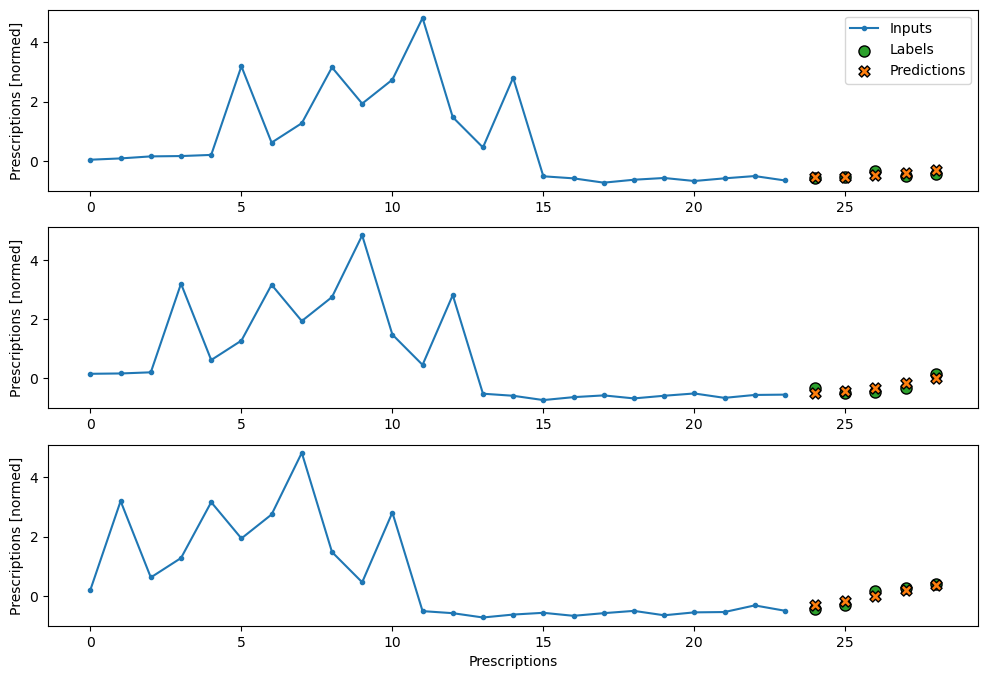

In [ ]:
# cell taken from notebook 3

## Conclusions

All three models produce relatively good evaluation metrics for test datasets, indicating reliability in their predictions forecasting approximately one year out. Proceeding to Notebook 4, I'll condense the ARIMA model, which allows the most direct manipulation of parameters, and apply forecasting to drugs for which there are current or expected shortages.

Using a constant prediction of the all-time mean of 153,236,124 for for all federal prescriptions returns an SMAPE of 17.17%. This will be the baseline for other models to meet. The most optimized single ARIMA model returns a train SMAPE of 14.66% and test SMAPE of 2.37% with the parameters p = 1, d = 3, q = 3 where the test SMAPE is being optimized. (In doing so there is some degree of data leakage through my choosing the optimized model.) Averaging the top 5 predictions results in a train SMAPE of 8.93% and test SMAPE of 2.64%.<Br>
- This means that the ARIMA model fits the data better than a flat-line prediction.<Br>
While the averaged model fits the training data significantly better than the top individual model, the test data increases slightly from 2.37% to 2.64% SMAPE.

While the Prophet model is not maximally optimized, adjusting "flexibility" in number of inflection points through the the `changepoint_prior_scale` parameter allows some tuning of the model. As the `changepoint_prior_scale` (set at 0.5*modifier) is increased, train SMAPE deccreases while test SMAPE increases. The best test SMAPE found is 1.33%, an improvement over the ARIMA model and extreme improvement over the flat-line projection. Parameters and the respective SMAPEs are shown in the table below.

|Modifier|Train SMAPE|Test SMAPE|
|---|---|---|
|0.5 |8.83% | 1.33%|
|1 |6.9% |1.64%|
|10 |4.6% |2.42%|
|1000 |3.96% |2.82%|

The RNN model does not currently provide a SMAPE, but does return Mean Average Error, MAE. In these terms the MAE is 0.1530 for the test dataset, reflecting a good fit at 1000 epochs.